# Sudoku Grid Detection

In [1]:
using Images
using ImageFiltering
using ImageBinarization
using OffsetArrays
using Plots
using FileIO
using Revise

In [2]:
Revise.includet("Utilities/Contours.jl");
using .Contours
Revise.includet("GridDetector/Transforms.jl")
using .Transforms

## Load image

In [3]:
image_path = "images/IMG_3637.jpg";

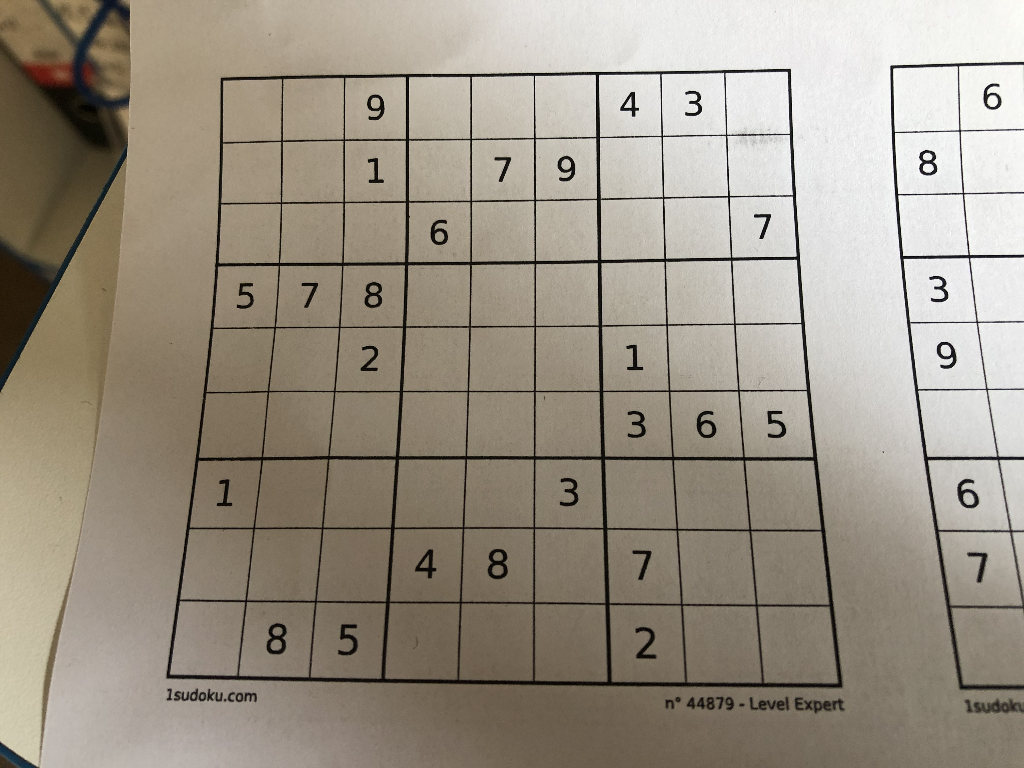

In [4]:
image_raw = load(image_path)
image = copy(image_raw)

max_size = 1024 
ratio = max_size/size(image, argmax(size(image)))
if ratio < 1
    image = imresize(image, ratio=ratio)
end

## Preprocess

In [5]:
window_size = 7;
σ = 1 # 0.3*((window_size - 1) * 0.5 - 1) + 0.8  # OpenCV default

1

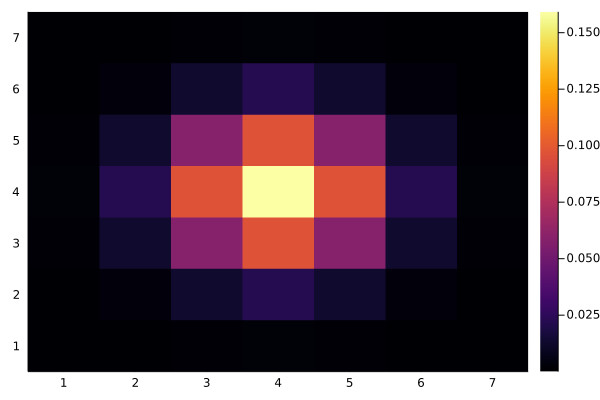

In [6]:
kernel = Kernel.gaussian((σ, σ), (window_size, window_size))
p = heatmap(1:window_size, 1:window_size, kernel)

In [7]:
gray = Gray.(image)
gray = imfilter(gray, kernel)
plot(hcat(Gray.(image_raw), gray),  size = (800, 400))

LoadError: ArgumentError: number of rows of each array must match (got (3024, 768))

In [8]:
function invert_image(image)
    image_inv = Gray.(image)
    height, width = size(image)
    for i in 1:height
        for j in 1:width
            image_inv[i, j] = 1 - image_inv[i, j]
        end
    end
    return image_inv
end;

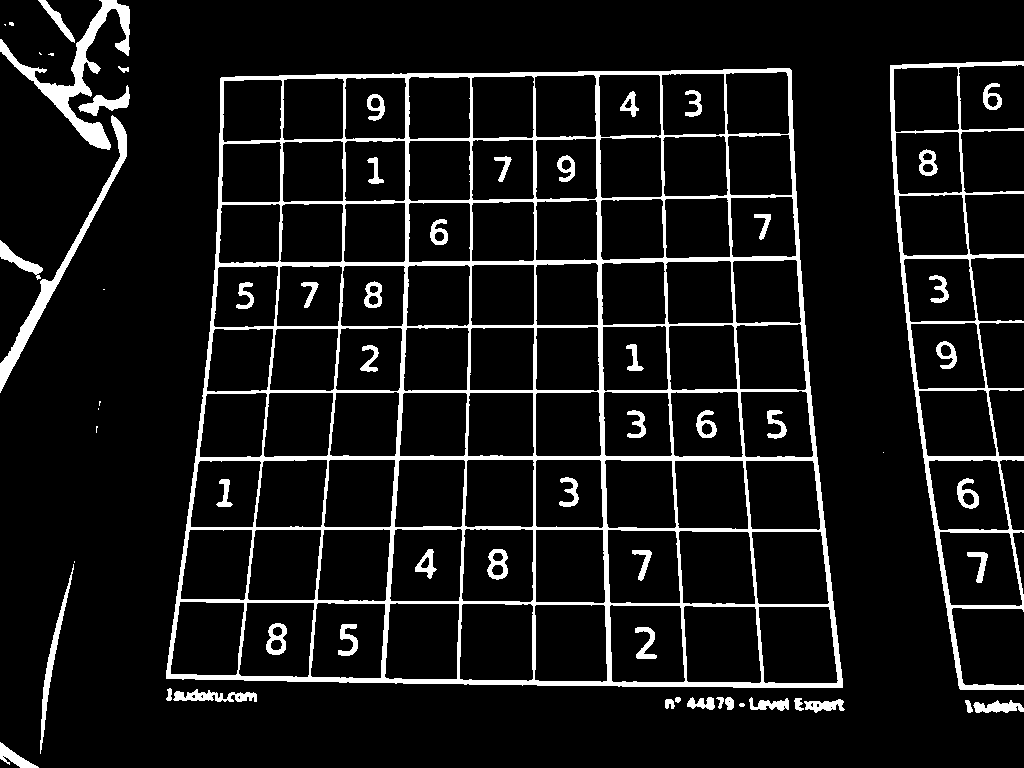

In [9]:
blackwhite = binarize(gray, AdaptiveThreshold(window_size=25))
blackwhite = invert_image(blackwhite)
blackwhite

## Contours

178
  0.033871 seconds (229.95 k allocations: 6.481 MiB, 83.95% compilation time)
  0.001250 seconds (46.31 k allocations: 1.065 MiB)


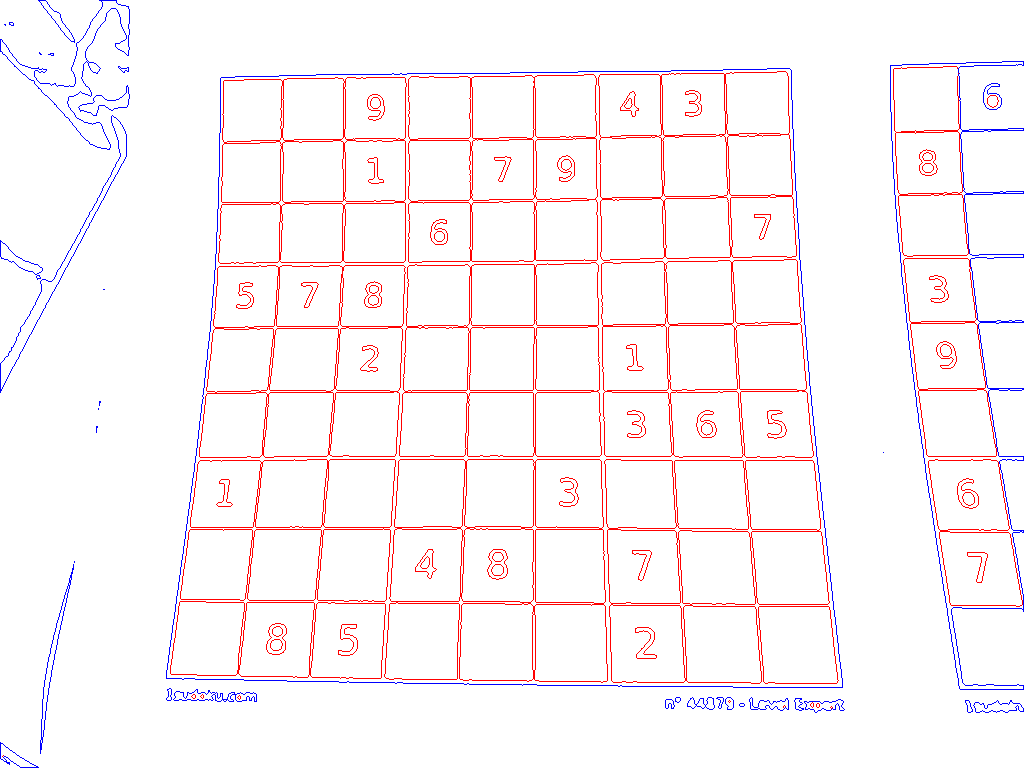

In [10]:
contours = find_contours(blackwhite)
println(length(contours))
img_contours = ones(RGB, size(image)) # copy(image)
@time draw_contours!(img_contours, RGB(1,0,0), contours)
contours = find_contours(blackwhite, external_only=true)
@time draw_contours!(img_contours, RGB(0,0,1), contours)
img_contours

  0.534760 seconds (1.66 M allocations: 88.240 MiB, 88.86% compilation time)


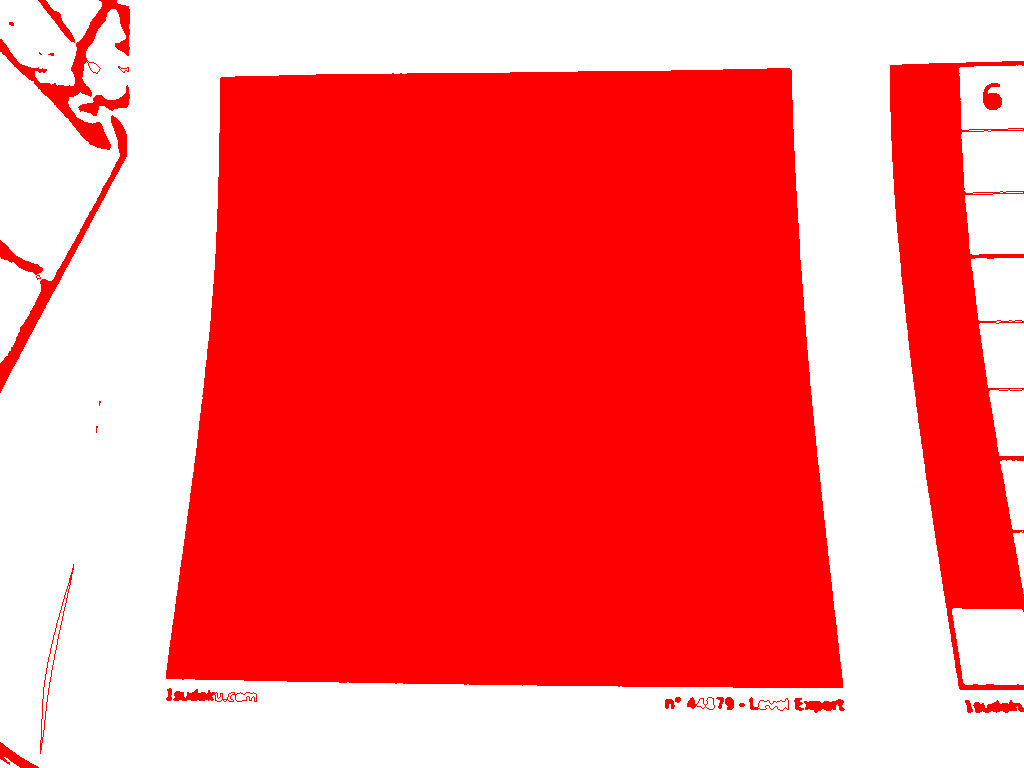

In [11]:
contours = find_contours(blackwhite, external_only=true)
img_contours = ones(RGB, size(image)) # copy(image)
@time fill_contours!(img_contours, RGB(1,0,0), contours)
img_contours

## Fit Rectangle

In [16]:
idx_max = argmax(map(calc_area_contour, contours))
max_contour = contours[idx_max]
rect = fit_rectangle(max_contour)
par = fit_parallelogram(max_contour)

4-element Vector{CartesianIndex{2}}:
 CartesianIndex(78, 222)
 CartesianIndex(679, 167)
 CartesianIndex(688, 843)
 CartesianIndex(71, 792)

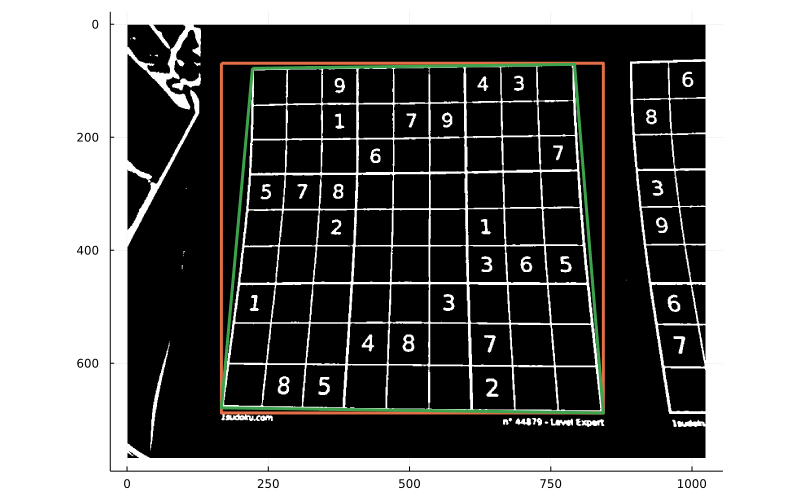

In [17]:
img_contours = RGB.(blackwhite)
p = plot(img_contours, size=(800, 500))
plot!(p, [point[2] for point in vcat(rect, rect[1])], [point[1] for point in vcat(rect, rect[1])], linewidth=3, label="")
plot!(p, [point[2] for point in vcat(par, par[1])], [point[1] for point in vcat(par, par[1])], linewidth=3, label="")

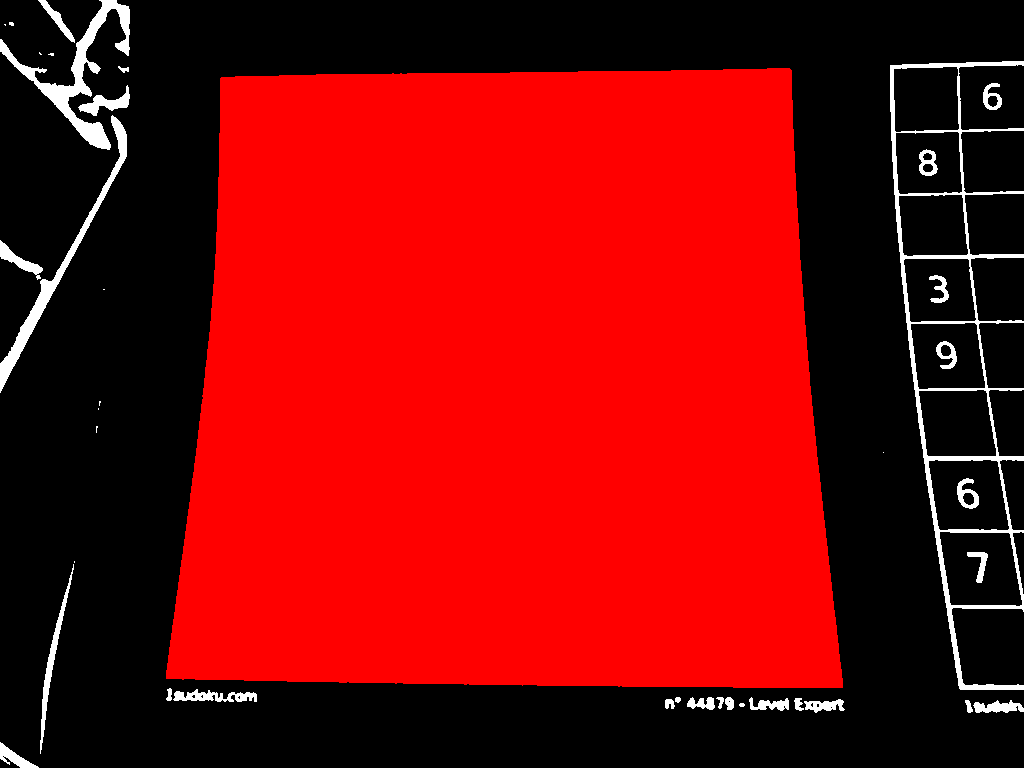

In [18]:
img_contours = RGB.(blackwhite)
fill_contour!(img_contours, RGB(1, 0, 0), max_contour)
img_contours

In [19]:
function apply_mask(image, mask)
    height, width = size(image)
    T = typeof(image).parameters[1]
    masked_image = zeros(T, size(image))
    for i in 1:height
        for j in 1:width
            masked_image[i, j] = mask[i, j] > 0 ? image[i, j] : zero(T)
        end
    end
    masked_image
end

apply_mask (generic function with 1 method)

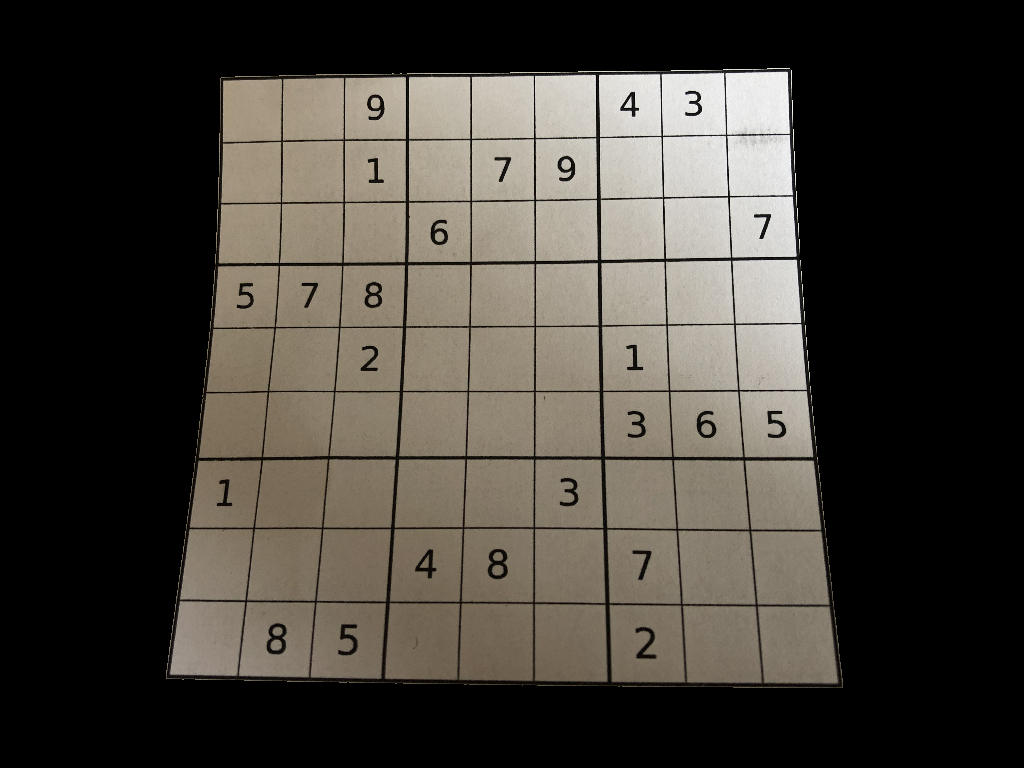

In [20]:
mask = zeros(size(image))
fill_contour!(mask, 1, max_contour)
masked_image = apply_mask(image, mask)
masked_image

## Straighten grid

In [21]:
using ImageTransformations, CoordinateTransformations
using StaticArrays

  0.965277 seconds (5.36 M allocations: 337.729 MiB, 7.15% gc time, 77.93% compilation time)


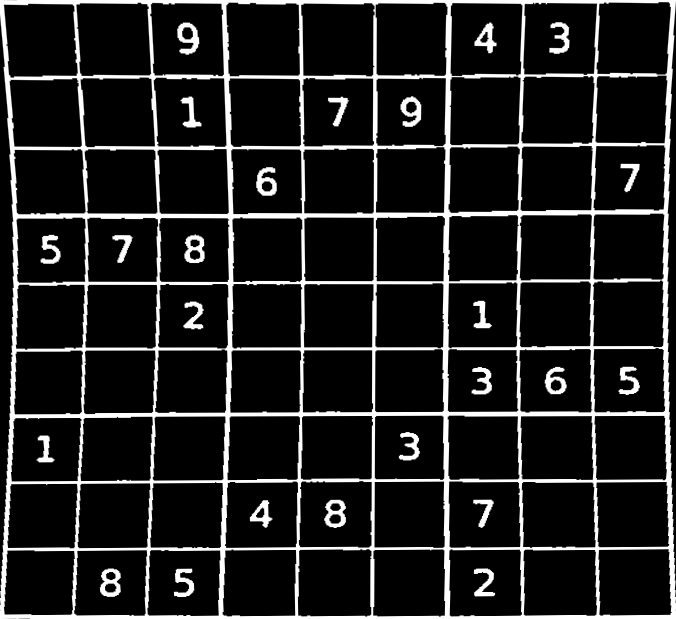

In [22]:
@time warped, invM = fourPointTransform(blackwhite, par)
warped

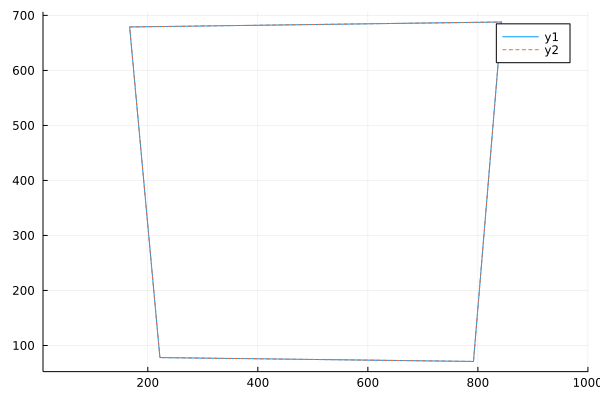

In [23]:
height, width = size(warped)
corners = [(1, 1), (1, width), (height, width), (height, 1)]
warped_corners = []
for corner in corners
    warped_corner = apply_homography(corner, invM)
    push!(warped_corners, warped_corner)
end
y = [point[1] for point in warped_corners]
x = [point[2] for point in warped_corners]
plot(vcat(x, x[1]), vcat(y, y[1]), aspectratio=1)

y = [point[1] for point in par]
x = [point[2] for point in par]
plot!(vcat(x, x[1]), vcat(y, y[1]), linestyle=:dash)